# Walkthrough: Electricity Price Discrepancy CH-DE

## Introduction and Motivation for the Analysis

This project investigates cross-border electricity pricing between Switzerland and Germany, focusing on whether auction prices at the border reflect day-ahead market price differences. Given the unique setup of the Swiss electricity market, which operates outside the European Market Coupling system, this analysis aims to uncover potential mispricing and market inefficiencies. By identifying patterns in pricing errors and assessing their behavior over time, the study contributes to understanding energy market dynamics, especially during periods of crisis or rapid renewable energy expansion.

We have the following hypotheses:
- The Convergence Hypothesis: The price difference between Germany and Switzerland, adjusted for border costs in both directions, equals zero. This equilibrium arises from arbitrage opportunities and the absence of transaction costs in JAO auctions.
- The Independence Hypothesis: Any observed pricing errors are uncorrelated over time, indicating no systematic patterns in their occurrence.
- The Volatility Growth Hypothesis: Pricing accuracy has deteriorated as solar capacity expansion creates more unpredictable supply-demand patterns.

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import os
import nbformat
from nbconvert.preprocessors import ExecutePreprocessor

from src.utils import test_stationarity, test_autocorr_specific_lag, test_variance_trend, run_hac_test, variance_ratio_test

## Data Preparation

The data collection and preparation process is detailed in **`1_process_data.ipynb`**. Here, we extract hourly electricity pricing data from 2016–2023, including auction prices from the Joint Allocation Office (JAO) and day-ahead prices from EPEX for both Switzerland and Germany. The output is a merged dataframe, that will be used in **`3_results.ipynb`** to evaluate the hypotheses. 

- First, make sure, that Day-Ahead Pricing data is in **`data/raw/`**. The datasets should have names of the form `{country code}_Day-ahead Prices_{Year}.csv` (e.g. `CH_Day-ahead Prices_2016.csv`). We put an example dataframe in the folder. The data can be retreived from Entso-E Transparency Platform for full years. 
- Second, make sure you have an API-key in src/config.py for JAO with KEY="...". `src/datafeed/upstream.py` holds the functions to manage the downloading process. 

`src/datafeed/downstream.py` is used to create the merged dataframe with the auction prices and the day ahead prices per hour:

In [ ]:
# Check if the preprocessed data from 1_process_data.ipynb exists. If not, this lets it run, so we can move on. 
file_path = 'data/processed/merged_data.csv'
if not os.path.exists(file_path):
    # If the file does not exist, run the notebook

    notebook_filename = 'notebooks/1_process_data.ipynb'
    with open(notebook_filename) as f:
        nb = nbformat.read(f, as_version=4)
    
    ep = ExecutePreprocessor(timeout=600, kernel_name='python3')
    ep.preprocess(nb, {'metadata': {'path': 'notebooks/'}})
    
    # Save the executed notebook
    with open(notebook_filename, 'w', encoding='utf-8') as f:
        nbformat.write(nb, f)
else:
    print(f"'{file_path}' already exists.")

In [3]:
df = pd.read_csv('data/processed/merged_data.csv', index_col=0, parse_dates=True, low_memory=False)

df = df.replace(['empty', 'n/e'], pd.NA)
df = df.apply(pd.to_numeric, errors='coerce')

print(df.head())

                        CH  DE-LU  DE-AT-LU  de-ch_auctionPrice  \
2016-01-01 00:00:00  41.09    NaN     23.86                9.26   
2016-01-01 01:00:00  40.16    NaN     22.39                8.50   
2016-01-01 02:00:00  36.03    NaN     20.59                8.87   
2016-01-01 03:00:00  33.59    NaN     16.81                7.50   
2016-01-01 04:00:00  32.92    NaN     17.41               10.02   

                     de-ch_requestedCapacity  de-ch_offeredCapacity  \
2016-01-01 00:00:00                   1663.0                  392.0   
2016-01-01 01:00:00                   1678.0                  392.0   
2016-01-01 02:00:00                   1678.0                  392.0   
2016-01-01 03:00:00                   1678.0                  392.0   
2016-01-01 04:00:00                   1668.0                  392.0   

                     ch-de_auctionPrice  ch-de_requestedCapacity  \
2016-01-01 00:00:00                 0.0                   2542.0   
2016-01-01 01:00:00               

## Variables

The analysis uses hourly data from 2016 to 2023, focusing on the following key variables:

| **Variable**            | **Description**                                                                                                  | **Unit**    |
|--------------------------|------------------------------------------------------------------------------------------------------------------|-------------|
| $p_t^{CH}$              | Day-ahead price in Switzerland                                                                                   | EUR/MWh     |
| $p_t^{DE}$              | Day-ahead price in Germany-Austria-Luxembourg (market region $DE-AT-LU$ before Oct 1, 2018; $DE-LU$ afterward)    | EUR/MWh     |
| $p_t^{CH \rightarrow DE}$ | Auction Price: Switzerland to Germany                                                                          | EUR/MWh     |
| $p_t^{DE \rightarrow CH}$ | Auction Price: Germany to Switzerland                                                                          | EUR/MWh     |
| Installed Capacity       | Yearly installed PV capacity in Switzerland                                                                     | MW          |
| Number of PV Units       | Total number of installed photovoltaic units                                                                    | Count       |

*Table: Variables used in the analysis.*

### Error Terms
- **Error Term ($\delta_t$):**  
  $$\delta_t = p_t^{DE} + p_t^{DE \rightarrow CH} - p_t^{CH} - p_t^{CH \rightarrow DE}$$  
  Captures deviations between the Swiss-German price spread and the auction price.

- **Normalized Error Term ($\hat{\delta}_t$):**  
  $$\hat{\delta}_t = \frac{\delta_t}{(p_t^{CH} + p_t^{DE}) / 2}$$  
  Adjusts for varying day-ahead price levels over time.



## Methodology

The methodology employed is outlined in **`2_methodology.ipynb`**. This notebook introduces statistical techniques used to evaluate pricing discrepancies and test the formulated hypotheses:
1. **Convergence Analysis:** Investigating whether price differences align with border costs.
2. **Temporal Dependency Tests:** Assessing correlations in pricing errors to detect systematic patterns.
3. **Volatility Analysis:** Measuring changes in pricing error volatility over time. 

## Results

Findings from the analysis are presented in **`3_results.ipynb`**. Highlights include:
- the weekly averaged difference of the two countries day-ahead prices align with border costs, as seen in the following plots:

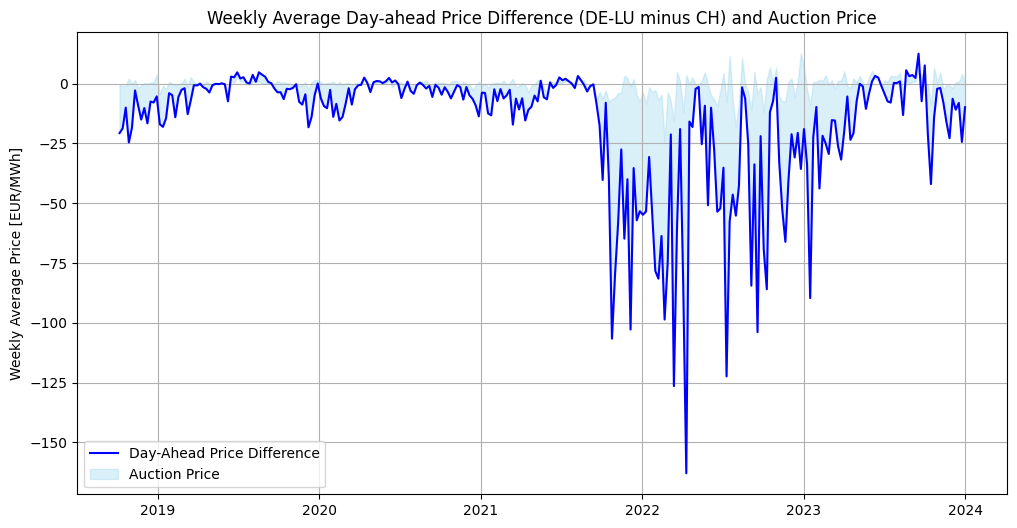

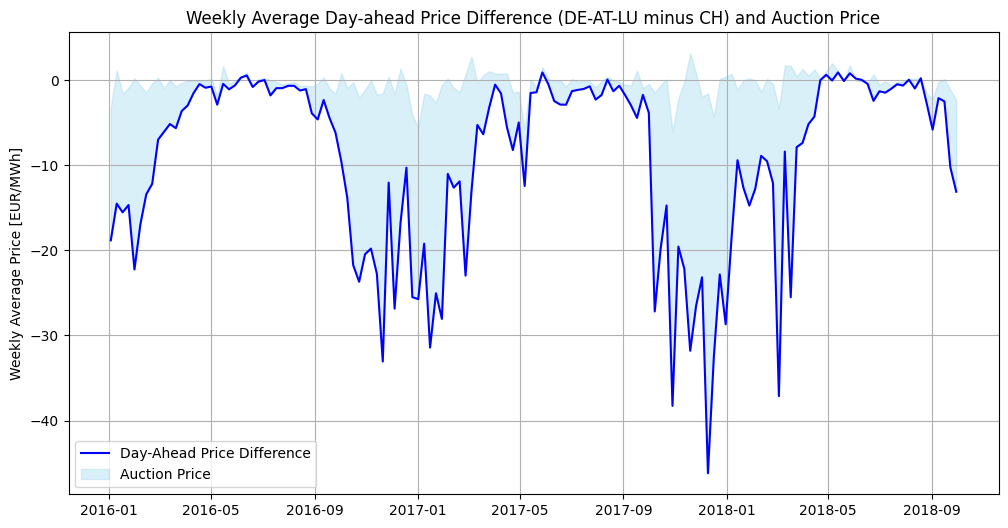

In [4]:
# Calculate Weekly averages for prices and auction data
weekly_df = df.resample('W').mean()

# Calculate price differences 
weekly_df['DE-LU_minus_CH'] = weekly_df['DE-LU'] - weekly_df['CH']
weekly_df['DE-AT-LU_minus_CH'] = weekly_df['DE-AT-LU'] - weekly_df['CH']

plt.figure(figsize=(12, 6))

# Plot DE-LU minus CH price difference
plt.plot(
   weekly_df.index,
   weekly_df['DE-LU_minus_CH'],
   label='Day-Ahead Price Difference',
   color='blue'
)

# Fill between price difference and auction price
plt.fill_between(
   weekly_df.index,
   weekly_df['DE-LU_minus_CH'],
   weekly_df['DE-LU_minus_CH'] + weekly_df['de-ch_auctionPrice'] - weekly_df['ch-de_auctionPrice'],
   color='skyblue',
   alpha=0.3,
   label='Auction Price'
)

plt.ylabel('Weekly Average Price [EUR/MWh]')
plt.title('Weekly Average Day-ahead Price Difference (DE-LU minus CH) and Auction Price')
plt.legend()
plt.grid(True)

plt.show()

# Same plot for DE-AT-LU
plt.figure(figsize=(12, 6))
plt.plot(
   weekly_df.index,
   weekly_df['DE-AT-LU_minus_CH'],
   label='Day-Ahead Price Difference',
   color='blue'
)

plt.fill_between(
   weekly_df.index,
   weekly_df['DE-AT-LU_minus_CH'],
   weekly_df['DE-AT-LU_minus_CH'] + weekly_df['de-ch_auctionPrice'] - weekly_df['ch-de_auctionPrice'],
   color='skyblue',
   alpha=0.3,
   label='Auction Price'
)

plt.ylabel('Weekly Average Price [EUR/MWh]')
plt.title('Weekly Average Day-ahead Price Difference (DE-AT-LU minus CH) and Auction Price')
plt.legend()
plt.grid(True)

plt.show()


In [5]:
# Calculate error series for DE-LU data
df_starting_2019 = df.loc['2019-01-01':].copy()
df_starting_2019['error'] = (df_starting_2019['CH'] - 
                                   df_starting_2019['DE-LU'] - 
                                   df_starting_2019['de-ch_auctionPrice'] +
                                   df_starting_2019['ch-de_auctionPrice'])

# 1. Test stationarity (ADF test)
stationarity_results = test_stationarity(df_starting_2019['error'])

# 2. HAC test using results.t_stat() instead of deprecated tvalues[0]
hac_results = run_hac_test(df_starting_2019['error'])

# 3. Test autocorrelation at lag 24
autocorr_results = test_autocorr_specific_lag(df_starting_2019['error'], 24)

# 4. Test if normalized variance is increasing over time
variance_trend_results = test_variance_trend(
   df_starting_2019['CH'],
   df_starting_2019['DE-LU'], 
   df_starting_2019['error']
)

variance_ratio_test_results = variance_ratio_test(
   df_starting_2019['CH'],
   df_starting_2019['DE-LU'], 
   df_starting_2019['error']
)

# Print results
print("Stationarity Test:")
print(f"ADF Statistic: {stationarity_results['adf_stat']:.4f}")
print(f"P-value: {stationarity_results['p_value']:.4f}")

print("\nHAC Test:")
print(f"T-test: {hac_results['t_stat']:.4f}")
print(f"P-value: {hac_results['p_value']:.4f}")

print("\nAutocorrelation Test (Lag 24):")
print(f"ACF: {autocorr_results['acf']:.4f}")
print(f"Z-statistic: {autocorr_results['z_stat']:.4f}")
print(f"P-value: {autocorr_results['p_value']:.4f}")

print("\nVariance Trend Test:")
print(f"Slope: {variance_trend_results['slope']:.4e}")
print(f"P-value: {variance_trend_results['p_value']:.4f}")
print(f"R-squared: {variance_trend_results['r_squared']:.4f}")

print("\nVariance Ratio Test:")
print(f"Variance Ratio: {variance_ratio_test_results['variance_ratio']:.4f}")
print(f"F-statistic: {variance_ratio_test_results['f_statistic']:.4f}")
print(f"P-value: {variance_ratio_test_results['p_value']:.4f}")
print(f"Degrees of Freedom (df1): {variance_ratio_test_results['df1']}")
print(f"Degrees of Freedom (df2): {variance_ratio_test_results['df2']}")

Stationarity Test:
ADF Statistic: -26.1123
P-value: 0.0000

HAC Test:
T-test: 2.1746
P-value: 0.0297

Autocorrelation Test (Lag 24):
ACF: 0.0206
Z-statistic: 4.3068
P-value: 0.0000

Variance Trend Test:
Slope: 1.0046e-05
P-value: 0.9585
R-squared: 0.0000

Variance Ratio Test:
Variance Ratio: 2.6850
F-statistic: 2.6850
P-value: 0.0000
Degrees of Freedom (df1): 21911
Degrees of Freedom (df2): 21911


### Statistical Results Interpretation

Stationarity Test (ADF)
- The Augmented Dickey-Fuller (ADF) test strongly indicates that the series is stationary, as the null hypothesis of a unit root is rejected with a highly significant p-value. This confirms that the series' statistical properties (mean, variance, and autocorrelation) are constant over time, making it suitable for time-series analysis.
- The HAC test result suggests that deviations between auction prices and implied price spreads are not purely random. A statistically significant t-statistic and p-value indicate potential structural inefficiencies or systematic biases in the market influencing these deviations.
- The autocorrelation at lag 24 is low but statistically significant. This reveals weak yet persistent patterns in the deviations, where past deviations have a slight influence on future ones, potentially hinting at recurring market behaviors.
- The variance trend test shows no significant trend in the variability of deviations over time. This suggests that market inefficiencies have neither increased nor decreased systematically during the observation period.
- The significant variance ratio indicates mean-reverting behavior in the deviations, with short-term variability exceeding long-term variability. This supports the notion that deviations are temporary and self-correcting over time.

## Discussion

This study sheds light on cross-border electricity pricing dynamics between Switzerland and Germany, focusing on the convergence, independence, and volatility growth hypotheses. The results confirm expected market behaviors while highlighting inefficiencies and temporal variations.

### Evaluation of Hypotheses

**Convergence Hypothesis**  
The stationarity of the error term $\delta_t$, supported by the ADF test, confirms the convergence hypothesis. Deviations from expected price differences are mean-reverting, even during volatile periods like the 2022 energy crisis. However, HAC tests reveal small but significant mean deviations in certain years (e.g., 2021–2022), pointing to potential inefficiencies due to structural or external factors.

**Independence Hypothesis**  
Autocorrelation at lag 24 indicates systematic dependencies in pricing errors during 2019–2020, likely caused by structural inefficiencies or forecast errors. From 2021 onward, autocorrelation diminishes, suggesting improved forecasting or market adjustments during periods of stress, such as the energy crisis.

**Volatility Growth Hypothesis**  
While the variance trend of $\hat{\delta}_t$ shows no consistent linear increase, the variance ratio test highlights a significant rise in volatility during 2022–2023. This may be driven by increased solar PV capacity or external stressors like geopolitical tensions and supply disruptions. Further investigation is needed to separate these effects.
